## Preprocessing and Modelling of capstone 3 :walmart weekly sales data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,TargetEncoder,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
# from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV, KFold


In [3]:
#pip show sklearn-compat :Name: sklearn-compat,Version: 0.1.3

In [4]:
#print(sklearn.__version__)

In [5]:
#if you do not like it degrade it like this 
#pip uninstall scikit-learn -y
#pip install scikit-learn==1.6.1
#print(sklearn.__version__)

In [6]:
#pip install --upgrade scikit-learn

In [7]:
#pip install scikit-learn==1.6.1

In [8]:
df = pd.read_csv('../EDA_cap3/data_eda_cap3.csv')

In [9]:
df.head()

,store,dept,date,weekly_sales,isholiday,type,size,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106


In [10]:
df.shape

(421570, 16)

In [11]:
df['date'] = pd.to_datetime(df['date'])

In [12]:
df_cat = df.select_dtypes(include=['category','object','bool'])

In [13]:
df_cat.columns

Index(['isholiday', 'type'], dtype='object')

### outlier removal 
* Outliers were handled using percentile-based capping, which limits extreme values while retaining all observations, ensuring stability without removing valid sales records.

In [14]:

# Calculate percentile bounds
lower = df['weekly_sales'].quantile(0.01)
upper = df['weekly_sales'].quantile(0.99)

# Create a new column with capped values
df['weekly_sales_c'] = df['weekly_sales'].clip(lower, upper)

In [15]:
print(df[['weekly_sales', 'weekly_sales_c']].describe())

        weekly_sales  weekly_sales_c
count  421570.000000   421570.000000
mean    15981.258123    15654.535929
std     22711.183519    20781.670902
min     -4988.940000        5.000000
25%      2079.650000     2079.650000
50%      7612.030000     7612.030000
75%     20205.852500    20205.852500
max    693099.360000   106479.586000


In [16]:
affected = (df['weekly_sales'] != df['weekly_sales_c']).sum()
print("Values capped:", affected)


Values capped: 8358


In [17]:
df = df.drop(columns = ['weekly_sales'])

In [18]:
for i in df_cat.columns:
    print(i,df[i].nunique())

isholiday 2
type 3


In [19]:
df_num = df.select_dtypes(include=['number'])

In [20]:
for i in df_num.columns:
    print(i,df[i].nunique())

store 45
dept 81
size 40
temperature 3528
fuel_price 892
markdown1 2278
markdown2 1499
markdown3 1662
markdown4 1945
markdown5 2294
cpi 2145
unemployment 349
weekly_sales_c 354230


In [21]:
cat_columns = ['store', 'dept', 'type', 'isholiday']

In [22]:
df_encoded = pd.get_dummies(df,columns=cat_columns,drop_first=True)

In [23]:
X = df_encoded.drop(columns =['weekly_sales_c','date'])
y = df_encoded['weekly_sales_c']

## Basic model 1

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Performance of basic model 1

In [25]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(X_test)

baseline_test_mae = mean_absolute_error(y_test, y_pred)
baseline_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
baseline_test_r2 = r2_score(y_test, y_pred)
print("\nBaseline Regression Performance")
print("baseline_test_mae :", baseline_test_mae)
print("baseline_test_rmse :", baseline_test_rmse)
print("baseline_test_r2 :", baseline_test_r2)
#print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


Baseline Regression Performance
baseline_test_mae : 7676.675723243547
baseline_test_rmse : 11394.436035401055
baseline_test_r2 : 0.6999788543790351


### Dummy Model 

In [26]:
from sklearn.dummy import DummyRegressor
#strategy="mean"=It predicts the average (mean) of y_train for every single row in X_test.
dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(X_train, y_train)

y_pred_dummy = dummy_mean.predict(X_test)

dummy_test_mae = mean_absolute_error(y_test, y_pred_dummy)
dummy_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
dummy_test_r2 = r2_score(y_test, y_pred_dummy)

print("Dummy Model Performance")
print("dummy_test_mae :", dummy_test_mae)
print("dummy_test_rmse :", dummy_test_rmse)
print("dummy_test_r2 :", dummy_test_r2)


Dummy Model Performance
dummy_test_mae : 14698.9819371981
dummy_test_rmse : 20802.57402704554
dummy_test_r2 : -8.009218457338818e-07


## Basic model 2

In [27]:
dt = DecisionTreeRegressor(max_depth=10,min_samples_split=20,min_samples_leaf=10,random_state=42)
dt.fit(X_train, y_train)
y_predds = dt.predict(X_test)

### Performance of basic model 2

In [28]:
print("MAE :", mean_absolute_error(y_test, y_predds))
print("R2  :", r2_score(y_test, y_predds))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
#print("RMSE:", mean_squared_error(y_test, y_predds, squared=False))

MAE : 8612.344702319531
R2  : 0.6528408803438368
RMSE: 11394.436035401055


In [29]:
#R² tells you how much of the pattern in the data your model understands.
#The model explains about 66% of the variance in weekly sales, with an average prediction error of around 8,164 in the same unit as the target variable.


### Feature engineering 

In [30]:
df.head()

,store,dept,date,isholiday,type,size,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,weekly_sales_c
0,1,1,2010-02-05,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,24924.50
1,1,1,2010-02-12,True,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,46039.49
2,1,1,2010-02-19,False,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,41595.55
3,1,1,2010-02-26,False,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,19403.54
4,1,1,2010-03-05,False,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,21827.90


In [31]:
## Extract calendar-based features from date
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week']  = df['date'].dt.dayofweek
#dfweekdayname = df['date'].dt.day_name() 4=friday , 5=saturday,6=sunday
df['is_weekend'] = (df['day_of_week']>=5).astype(int)

In [32]:
df.columns

Index(['store', 'dept', 'date', 'isholiday', 'type', 'size', 'temperature',
       'fuel_price', 'markdown1', 'markdown2', 'markdown3', 'markdown4',
       'markdown5', 'cpi', 'unemployment', 'weekly_sales_c', 'year', 'month',
       'day_of_week', 'is_weekend'],
      dtype='object')

In [33]:
#Sales per store size
# Normalize sales by store size
df["sales_per_sqft"] = df["weekly_sales_c"] / df["size"]

In [34]:
## Create promotion indicator and total promotion value
markdown_cols = ['markdown1','markdown2','markdown3','markdown4','markdown5']
df['has_promotion'] = (df[markdown_cols].sum(axis=1) > 0).astype(int)

In [35]:
df['promo_total_value'] = df[markdown_cols].sum(axis=1)

In [36]:
## Bucket fuel prices to capture non-linear effects
# df['fuel_price_bucket'] = pd.qcut(df['fuel_price'], 3, labels=['low','med','high'])
df['fuel_price_bucket'] = pd.qcut(df['fuel_price'], 3, labels=['low','med','high'])

In [37]:
df.columns

Index(['store', 'dept', 'date', 'isholiday', 'type', 'size', 'temperature',
       'fuel_price', 'markdown1', 'markdown2', 'markdown3', 'markdown4',
       'markdown5', 'cpi', 'unemployment', 'weekly_sales_c', 'year', 'month',
       'day_of_week', 'is_weekend', 'sales_per_sqft', 'has_promotion',
       'promo_total_value', 'fuel_price_bucket'],
      dtype='object')

In [38]:
df.shape

(421570, 24)

In [39]:
df.head()

,store,dept,date,isholiday,type,size,temperature,fuel_price,markdown1,markdown2,...,unemployment,weekly_sales_c,year,month,day_of_week,is_weekend,sales_per_sqft,has_promotion,promo_total_value,fuel_price_bucket
0,1,1,2010-02-05,False,A,151315,42.31,2.572,0.0,0.0,...,8.106,24924.50,2010,2,4,0,0.164719,0,0.0,low
1,1,1,2010-02-12,True,A,151315,38.51,2.548,0.0,0.0,...,8.106,46039.49,2010,2,4,0,0.304263,0,0.0,low
2,1,1,2010-02-19,False,A,151315,39.93,2.514,0.0,0.0,...,8.106,41595.55,2010,2,4,0,0.274894,0,0.0,low
3,1,1,2010-02-26,False,A,151315,46.63,2.561,0.0,0.0,...,8.106,19403.54,2010,2,4,0,0.128233,0,0.0,low
4,1,1,2010-03-05,False,A,151315,46.50,2.625,0.0,0.0,...,8.106,21827.90,2010,3,4,0,0.144255,0,0.0,low


In [40]:
df_cat = df.select_dtypes(include=['category','object','bool'])
df_cat.columns

Index(['isholiday', 'type', 'fuel_price_bucket'], dtype='object')

In [41]:
for i in df_cat.columns:
    print(i,df[i].nunique())

isholiday 2
type 3
fuel_price_bucket 3


In [42]:
df_num = df.select_dtypes(include=['number'])

In [43]:
for i in df_num.columns:
    print(i,df[i].nunique())

store 45
dept 81
size 40
temperature 3528
fuel_price 892
markdown1 2278
markdown2 1499
markdown3 1662
markdown4 1945
markdown5 2294
cpi 2145
unemployment 349
weekly_sales_c 354230
year 3
month 12
day_of_week 1
is_weekend 1
sales_per_sqft 399895
has_promotion 2
promo_total_value 2296


In [44]:
#df.loc[df['day_of_week']==4]

In [45]:
df['is_weekend'].nunique()

1

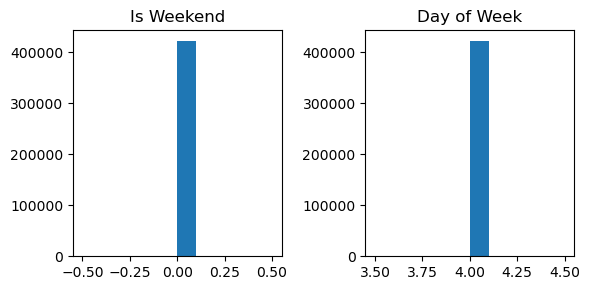

In [46]:
### histogram of is weekend and day of week 
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].hist(df['is_weekend'])
axes[0].set_title('Is Weekend')

axes[1].hist(df['day_of_week'])
axes[1].set_title('Day of Week')

plt.tight_layout()
plt.show()

In [47]:
#df.isnull().sum()- zero null values 

In [48]:
df_cat.columns

Index(['isholiday', 'type', 'fuel_price_bucket'], dtype='object')

In [49]:
df_num.columns

Index(['store', 'dept', 'size', 'temperature', 'fuel_price', 'markdown1',
       'markdown2', 'markdown3', 'markdown4', 'markdown5', 'cpi',
       'unemployment', 'weekly_sales_c', 'year', 'month', 'day_of_week',
       'is_weekend', 'sales_per_sqft', 'has_promotion', 'promo_total_value'],
      dtype='object')

In [50]:
target = ['weekly_sales_c']
num_column = ['size', 'temperature', 'fuel_price', 'markdown2', 'markdown3', 'cpi',
       'unemployment', 'year', 'month','sales_per_sqft', 'has_promotion', 'promo_total_value']
#'markdown1', 'markdown4', 'markdown5 are not contributing in model 

In [51]:
cat_clm_low = ['isholiday', 'type','fuel_price_bucket']
#cat_clm_low = ['isholiday', 'type','fuel_price_bucket','store', 'dept']

In [52]:
df.columns

Index(['store', 'dept', 'date', 'isholiday', 'type', 'size', 'temperature',
       'fuel_price', 'markdown1', 'markdown2', 'markdown3', 'markdown4',
       'markdown5', 'cpi', 'unemployment', 'weekly_sales_c', 'year', 'month',
       'day_of_week', 'is_weekend', 'sales_per_sqft', 'has_promotion',
       'promo_total_value', 'fuel_price_bucket'],
      dtype='object')

In [53]:
df1 = df.drop(columns = ['markdown1', 'markdown4', 'markdown5','day_of_week', 'is_weekend'])

In [54]:
#cat_fuel =['fuel_price_bucket']

In [55]:
cat_clm_high = ['store', 'dept']

### Train test Split 


In [56]:
df1["date"] = pd.to_datetime(df1["date"])
df1 = df1.sort_values(by="date")

In [57]:
df1['date'].min(),df1['date'].max()

(Timestamp('2010-02-05 00:00:00'), Timestamp('2012-10-26 00:00:00'))

In [58]:
#split data for train and test latest data is for test
split_date = df1["date"].max() - pd.DateOffset(months=6)
train_df = df1[df1["date"] < split_date]
test_df  = df1[df1["date"] >= split_date]
X_train = train_df.drop("weekly_sales_c", axis=1)
y_train = train_df["weekly_sales_c"]

X_test  = test_df.drop("weekly_sales_c", axis=1)
y_test  = test_df["weekly_sales_c"]

In [59]:
X_train.head()

,store,dept,date,isholiday,type,size,temperature,fuel_price,markdown2,markdown3,cpi,unemployment,year,month,sales_per_sqft,has_promotion,promo_total_value,fuel_price_bucket
0,1,1,2010-02-05,False,A,151315,42.31,2.572,0.0,0.0,211.096358,8.106,2010,2,0.164719,0,0.0,low
277665,29,5,2010-02-05,False,B,93638,24.36,2.788,0.0,0.0,131.527903,10.064,2010,2,0.166087,0,0.0,low
277808,29,6,2010-02-05,False,B,93638,24.36,2.788,0.0,0.0,131.527903,10.064,2010,2,0.034177,0,0.0,low
277951,29,7,2010-02-05,False,B,93638,24.36,2.788,0.0,0.0,131.527903,10.064,2010,2,0.115552,0,0.0,low
278094,29,8,2010-02-05,False,B,93638,24.36,2.788,0.0,0.0,131.527903,10.064,2010,2,0.214183,0,0.0,low


In [60]:
# X = df1.drop(columns = "weekly_sales_c")
# y = df1["weekly_sales_c"]
# X_train,X_test,y_train,y_test = train_test_split(X,y, test_size =0.2, shuffle = True,random_state=43)

In [61]:
# Logistic Regression needs scaling
from sklearn.impute import SimpleImputer
num_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())])

In [62]:
cat_low_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),("onehot", OneHotEncoder(handle_unknown="ignore",sparse_output=False))])
#cat_low_pipe = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

In [63]:
#cat_fuel = Pipeline(steps=[('ordinal',OrdinalEncoder(handle_unknown="ignore") )])

In [64]:
cat_high_pipe = Pipeline(steps = [("imputer", SimpleImputer(strategy="most_frequent")),
                                  ('target',TargetEncoder(categories="auto",target_type="continuous", smooth="auto",cv=3,shuffle=False))])

In [65]:
preprocess_linear = ColumnTransformer(transformers =[('num',num_pipe,num_column),('cat_low',cat_low_pipe,cat_clm_low),
                                                     ('cat_high',cat_high_pipe,cat_clm_high)])
#preprocess_linear = ColumnTransformer(transformers =[('num',num_pipe,num_column),('cat_low',cat_low_pipe,cat_clm_low)])

 ## Modelling 
 ### 1. Linear Regression Model

In [66]:
lr =  LinearRegression()
model_lr = Pipeline(steps=[('preprocess',preprocess_linear),('lrn',lr)])
model_lr.fit(X_train,y_train)
y_pred_lr = model_lr.predict(X_test)

### Cross validation of LR model

In [67]:
# from sklearn.model_selection import KFold, cross_val_score

# kf = KFold(n_splits=3,shuffle=True,random_state=42)

# cv_rmse = -cross_val_score(model_lr,X_train,y_train,cv=kf,scoring="neg_root_mean_squared_error",n_jobs=-1)
# print("CV RMSE (per fold):", cv_rmse)
# print("CV RMSE mean:", cv_rmse.mean())
# print("CV RMSE std :", cv_rmse.std())

# Time series based validation
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cv_rmse = -cross_val_score(model_lr,X_train,y_train,cv=tscv,scoring="neg_root_mean_squared_error", n_jobs=-1)

print("TimeSeries CV RMSE (per fold):", cv_rmse)
print("TimeSeries CV RMSE mean:", cv_rmse.mean())
print("TimeSeries CV RMSE std :", cv_rmse.std())

TimeSeries CV RMSE (per fold): [10079.66753337  9441.17444922 10146.12542196]
TimeSeries CV RMSE mean: 9888.989134852234
TimeSeries CV RMSE std : 317.8130029213804


### Performance of linear regression model

In [68]:

lr_test_mae = mean_absolute_error(y_test, y_pred_lr)
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
lr_test_r2 = r2_score(y_test, y_pred_lr)

y_train_pred_lr = model_lr.predict(X_train)
lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))

print("\nLinear Regression Performance")
print("lr_test_mae :", lr_test_mae)
print("lr_test_rmse :", lr_test_rmse)
print("lr_test_r2 :", lr_test_r2)
print("lr_train_rmse :", lr_train_rmse)



Linear Regression Performance
lr_test_mae : 6530.919539521432
lr_test_rmse : 9504.695828099275
lr_test_r2 : 0.7865117886721935
lr_train_rmse : 9706.429906616266


In [69]:
# Get the linear regression model from pipeline
lr_estimator = model_lr.named_steps['lrn']
# Get coefficients (these are the feature importances!)
coefficients = lr_estimator.coef_
intercept = lr_estimator.intercept_
print(f"Model intercept: {intercept:.2f}")
print(f"Number of coefficients: {len(coefficients)}")

Model intercept: -4496.46
Number of coefficients: 22


In [70]:
# Get feature names after preprocessing
preprocessor = model_lr.named_steps['preprocess']
all_features = preprocessor.get_feature_names_out()
print("Total features:", len(all_features))
print(all_features[:20])

Total features: 22
['num__size' 'num__temperature' 'num__fuel_price' 'num__markdown2'
 'num__markdown3' 'num__cpi' 'num__unemployment' 'num__year' 'num__month'
 'num__sales_per_sqft' 'num__has_promotion' 'num__promo_total_value'
 'cat_low__isholiday_False' 'cat_low__isholiday_True' 'cat_low__type_A'
 'cat_low__type_B' 'cat_low__type_C' 'cat_low__fuel_price_bucket_high'
 'cat_low__fuel_price_bucket_low' 'cat_low__fuel_price_bucket_med']


In [71]:
# Numeric features (unchanged) (manually created features): not working 
# numeric_features = num_column
# # Categorical features (after OneHotEncoding)
# onehot_encoder = preprocessor.named_transformers_['cat_low'].named_steps['onehot']
# cat_features = onehot_encoder.get_feature_names_out(cat_low)
# # all feature names
# all_features = list(numeric_features)+list(cat_features)
# print(f'\n total feature after encoding: {len(all_features)}')

In [72]:
# create feature importance dataframe
lr_importance_df = pd.DataFrame({"feature": all_features,
                                "coefficient":coefficients,
                                "abs_coefficient":np.abs(coefficients)})

lr_importance_df = lr_importance_df.sort_values("abs_coefficient",ascending = False).reset_index(drop=True)

# Add percentage contribution
total_abs_coef = lr_importance_df['abs_coefficient'].sum()
lr_importance_df['importance_pct'] = ( lr_importance_df['abs_coefficient'] / total_abs_coef * 100)

In [73]:
lr_importance_df

,feature,coefficient,abs_coefficient,importance_pct
0,num__sales_per_sqft,9314.367110,9314.367110,44.629053
1,num__size,3880.838062,3880.838062,18.594729
2,cat_low__type_C,-2325.045670,2325.045670,11.140272
3,cat_low__type_B,2026.174983,2026.174983,9.708257
4,num__year,-555.729627,555.729627,2.662735
5,num__has_promotion,422.399396,422.399396,2.023893
6,num__month,377.791065,377.791065,1.810156
7,num__fuel_price,357.557771,357.557771,1.713210
8,num__temperature,-300.191131,300.191131,1.438342
9,cat_low__type_A,298.870687,298.870687,1.432015


In [74]:
#lr_importance_df.head()

### absolute feature decide the strength of impact and positive neagtive sign define direction of impact

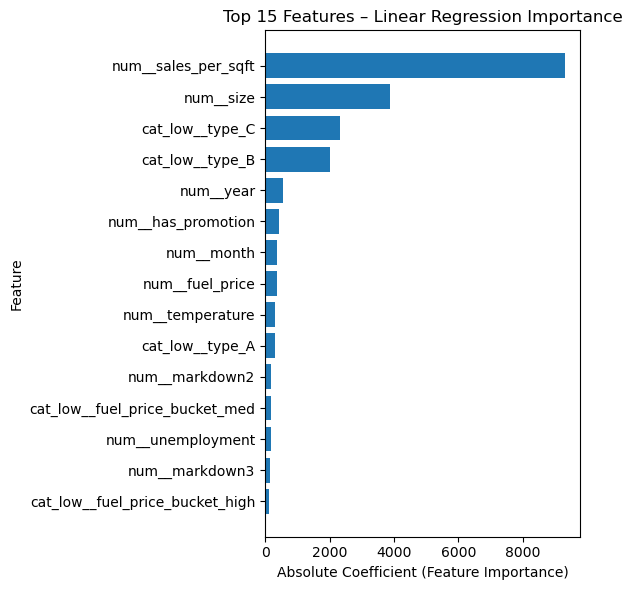

In [75]:
top_feats = (lr_importance_df.sort_values(by="importance_pct", ascending=False).head(15))
plt.figure(figsize=(6, 6))
plt.barh(top_feats["feature"], top_feats["abs_coefficient"])
plt.xlabel("Absolute Coefficient (Feature Importance)")
plt.ylabel("Feature")
plt.title("Top 15 Features – Linear Regression Importance")
plt.gca().invert_yaxis()  # highest importance on top
plt.tight_layout()
plt.show()

In [76]:
pos_coefficients = lr_importance_df[lr_importance_df['coefficient']> 0].sort_values('importance_pct',ascending=False).head(10)
neg_coefficients = lr_importance_df[lr_importance_df['coefficient']<=0].sort_values('importance_pct',ascending=False).head(10)

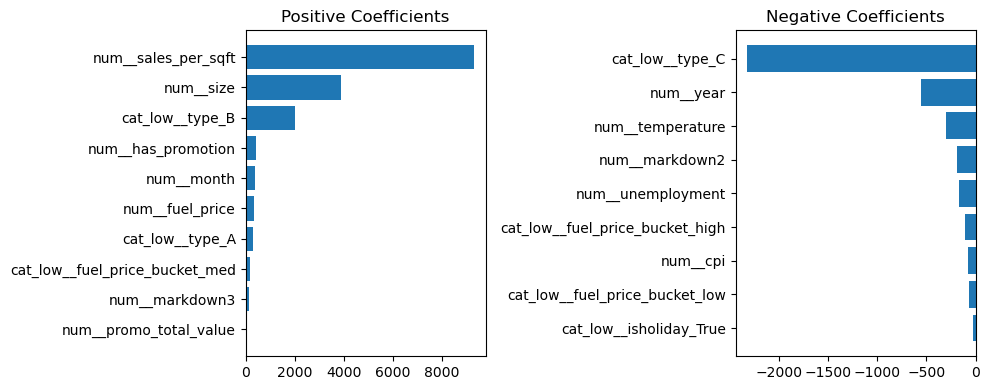

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Positive coefficients
axes[0].barh(pos_coefficients["feature"],pos_coefficients["coefficient"])
axes[0].set_title("Positive Coefficients")
axes[0].invert_yaxis()

# Negative coefficients
axes[1].barh(neg_coefficients["feature"],neg_coefficients["coefficient"])
axes[1].set_title("Negative Coefficients")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [78]:
y_train.shape

(341713,)

In [79]:
y_train_1d = y_train.squeeze()          # converts (n,1) -> (n,)
y_train_1d = y_train_1d.astype(float)
print(y_train_1d.shape)

(341713,)


In [80]:
import statsmodels.api as sm

#1. Transform X using your ColumnTransformer
X_train_transformed = preprocess_linear.fit_transform(X_train,y_train_1d)
#2. Get feature names (VERY IMPORTANT)
feature_names = preprocess_linear.get_feature_names_out()
#print(feature_names)

In [81]:
# 3.convert into dataframe
X_train_df =pd.DataFrame(X_train_transformed,columns =feature_names,index=X_train.index)


In [82]:
# 4 Add intercept (constant)
X_train_df =sm.add_constant(X_train_df)

In [83]:
# 5 Fit OLS model
ols_model = sm.OLS(y_train_1d, X_train_df).fit()
# 6 Get full summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         weekly_sales_c   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                 6.436e+04
Date:                Fri, 06 Feb 2026   Prob (F-statistic):               0.00
Time:                        13:49:01   Log-Likelihood:            -3.6230e+06
No. Observations:              341713   AIC:                         7.246e+06
Df Residuals:                  341693   BIC:                         7.246e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [84]:
pvals = ols_model.pvalues
# Keep features with p-value < 0.05 (excluding intercept)
significant_features = pvals[(pvals < 0.05) & (pvals.index != 'const')]
print(significant_features)

num__size                           0.000000e+00
num__temperature                    7.487832e-48
num__fuel_price                     1.412811e-09
num__markdown2                      4.331223e-18
num__markdown3                      1.700152e-11
num__cpi                            8.597985e-05
num__unemployment                   1.736555e-18
num__year                           7.058377e-25
num__month                          1.972320e-61
num__sales_per_sqft                 0.000000e+00
num__has_promotion                  6.781171e-37
cat_low__isholiday_False           1.134675e-194
cat_low__isholiday_True            7.030625e-120
cat_low__type_A                     1.230745e-20
cat_low__type_B                     0.000000e+00
cat_low__type_C                     0.000000e+00
cat_low__fuel_price_bucket_high     2.359642e-36
cat_low__fuel_price_bucket_low      1.002872e-31
cat_low__fuel_price_bucket_med      2.685818e-58
cat_high__store                     0.000000e+00
cat_high__dept      

In [85]:
#from sklearn.model_selection import TimeSeriesSplit, cross_val_score

## 2. Ridge Model

In [86]:
# 1.Build  Ridge Pipeline (Preprocess + Model)

In [87]:
ridge = Ridge(alpha=1.0)
ridge_model = Pipeline([("preprocess", preprocess_linear),("reg",ridge )])

ridge_model.fit(X_train, y_train)
y_pred_ridge= ridge_model.predict(X_test)

### Cross-validation of ridge model (estimate performance on train only)

In [88]:
# from sklearn.model_selection import KFold, cross_val_score

# kf = KFold(n_splits=3,shuffle=True,random_state=42)

# cv_rsme = -cross_val_score(ridge_model,X_train,y_train,cv=kf,scoring="neg_root_mean_squared_error",n_jobs=-1)
# print("CV RMSE (per fold):", cv_rmse)
# print("CV RMSE mean:", cv_rmse.mean())
# print("CV RMSE std :", cv_rmse.std())

In [89]:
# Time series based validation
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cv_rmse = -cross_val_score(
    ridge_model,
    X_train,
    y_train,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

print("TimeSeries CV RMSE (per fold):", cv_rmse)
print("TimeSeries CV RMSE mean:", cv_rmse.mean())
print("TimeSeries CV RMSE std :", cv_rmse.std())

TimeSeries CV RMSE (per fold): [10079.6825641   9441.17372587 10146.12364193]
TimeSeries CV RMSE mean: 9888.99331063082
TimeSeries CV RMSE std : 317.8158686835778


### Performance of Ridge Model

In [90]:

ridge_test_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_test_r2 = r2_score(y_test, y_pred_ridge)

y_train_pred_ridge = ridge_model.predict(X_train)
ridge_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
print("\nRidge Regression Performance")
print("ridge_test_mae :", ridge_test_mae)
print("ridge_test_rmse :", ridge_test_rmse)
print("ridge_test_r2 :", ridge_test_r2)
print("ridge_train_rmse :", ridge_train_rmse)



Ridge Regression Performance
ridge_test_mae : 6530.921054174829
ridge_test_rmse : 9504.693560738002
ridge_test_r2 : 0.7865118905281295
ridge_train_rmse : 9706.429605428546


## Tree based modelling

In [91]:
df.shape

(421570, 24)

In [92]:
target = ['weekly_sales_c']
num_column = ['size','temperature', 'fuel_price', 'markdown2', 'markdown3', 'cpi',
       'unemployment', 'year', 'month', 'has_promotion', 'promo_total_value']
#'markdown1', 'markdown4', 'markdown5 are not contributing in model

In [93]:
cat_clm_low = ['isholiday', 'type','fuel_price_bucket']
#cat_clm_low = ['isholiday', 'type','fuel_price_bucket','store', 'dept']

In [94]:
# df = df.drop(columns = ['markdown1', 'markdown4', 'markdown5','day_of_week', 'is_weekend'])
df2 = df.drop(columns = ['sales_per_sqft','markdown1', 'markdown4', 'markdown5','day_of_week', 'is_weekend'])

In [95]:
# X = df2.drop(columns = "weekly_sales_c")
# y = df2["weekly_sales_c"]
# X_train,X_test,y_train,y_test = train_test_split(X,y, test_size =0.3, shuffle = True,random_state=43)

In [96]:
df2["date"] = pd.to_datetime(df2["date"])
df2 = df2.sort_values(by="date")

In [97]:
df2['date'].min(),df2['date'].max()

(Timestamp('2010-02-05 00:00:00'), Timestamp('2012-10-26 00:00:00'))

In [98]:
#split data for train and test latest data is for test
split_date = df2["date"].max() - pd.DateOffset(months=6)
train_df = df2[df2["date"] < split_date]
test_df  = df2[df2["date"] >= split_date]
X_train = train_df.drop("weekly_sales_c", axis=1)
y_train = train_df["weekly_sales_c"]

X_test  = test_df.drop("weekly_sales_c", axis=1)
y_test  = test_df["weekly_sales_c"]

In [99]:
train_df.shape

(341713, 18)

In [100]:
test_df.shape, len(test_df)/len(train_df)

((79857, 18), 0.23369611340510896)

In [101]:
from sklearn.impute import SimpleImputer
num_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())])

In [102]:
cat_low_pipe = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),("onehot", OneHotEncoder(handle_unknown="ignore",sparse_output=False))])
#cat_low_pipe = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

In [103]:
cat_high_pipe = Pipeline(steps = [("imputer", SimpleImputer(strategy="most_frequent")),
                                  ('target',TargetEncoder(categories="auto",target_type="continuous", smooth="auto",cv=3,shuffle=False))])

In [104]:
preprocess_tree = ColumnTransformer(transformers =[('num','passthrough',num_column),('cat_low',cat_low_pipe,cat_clm_low),
                                                  ('cat_high',cat_high_pipe,cat_clm_high)])
#preprocess_tree = ColumnTransformer(transformers =[('num','passthrough',num_column),('cat_low',cat_low_pipe,cat_clm_low)])

In [105]:
# DecisionTreeRegressor
#ds = DecisionTreeRegressor(max_depth=10,
#         min_samples_split=20,
#         min_samples_leaf=10,
#         random_state=42)
# ds_model = Pipeline(steps =[('preprocess_tree',preprocess_tree),('ds',ds)])
# ds_model.fit(X_train,y_train)
# y_pred_ds = ds_model.predict(X_test)
# print("ds_MAE:", mean_absolute_error(y_test, y_pred_ds))
# print("ds_R2:", r2_score(y_test, y_pred_ds))
# rmse = np.sqrt(mean_squared_error(y_test, y_pred_ds))
# print("ds_RMSE:", rmse)
# #print("ds_RMSE:" mean_squared_error(y_test, y_pred_ds),squared=False)
# y_train_pred = ds_model.predict(X_train)
# train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
# print("Train RMSE:", train_rmse)

## 3. Random Forest model 

In [106]:
from sklearn.ensemble import RandomForestRegressor 

In [107]:

rf = RandomForestRegressor(
    n_estimators=200,        # number of trees
    max_depth=8,            # max depth of each tree
    min_samples_split=15,    # min samples to split a node
    min_samples_leaf=12,      # min samples at a leaf node
    max_features=0.5,     # features considered at each split,"sqrt",0.5
    random_state=42,
    n_jobs=-1
)
rf_model = Pipeline(steps=[('preprocess_tree',preprocess_tree),('random_forest',rf)])
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

### cross validaion steps

In [108]:
## cross validaion steps
# from sklearn.model_selection import KFold, cross_val_score

# kf = KFold(n_splits=3,shuffle=True,random_state=42)

# cv_rsme = -cross_val_score(rf_model,X_train,y_train,cv=kf,scoring="neg_root_mean_squared_error",n_jobs=-1)
# print("CV RMSE (per fold):", cv_rmse)
# print("CV RMSE mean:", cv_rmse.mean())
# print("CV RMSE std :", cv_rmse.std())

In [109]:
## time based cross validation
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cv_rmse = -cross_val_score(
    rf_model,
    X_train,
    y_train,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

print("TimeSeries CV RMSE (per fold):", cv_rmse)
print("TimeSeries CV RMSE mean:", cv_rmse.mean())
print("TimeSeries CV RMSE std :", cv_rmse.std())

TimeSeries CV RMSE (per fold): [9162.3498862  7417.34587599 8869.24450955]
TimeSeries CV RMSE mean: 8482.98009057996
TimeSeries CV RMSE std : 762.9591076565387


### Performance of Random Forest model 

In [110]:

rf_test_mae = mean_absolute_error(y_test, y_pred_rf)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_test_r2 = r2_score(y_test, y_pred_rf)

y_train_pred_rf = rf_model.predict(X_train)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))

print("\nRandom Forest Performance")
print("rf_test_mae :", rf_test_mae)
print("rf_test_rmse :", rf_test_rmse)
print("rf_test_r2 :", rf_test_r2)
print("rf_train_rmse :", rf_train_rmse)



Random Forest Performance
rf_test_mae : 4593.071897534607
rf_test_rmse : 7372.859917983872
rf_test_r2 : 0.8715395563363222
rf_train_rmse : 7797.001727699723


## 4. XGboost Regressor model 

In [111]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

# xgb = XGBRegressor(
#     n_estimators=500,
#     max_depth=6,
#     learning_rate=0.1, #0.05 is also good 
#     subsample=0.8,
#     colsample_bytree=0.8,
#     objective="reg:squarederror",
#     random_state=42,
#     n_jobs=-1 )
xgb = XGBRegressor(
    n_estimators=450,          
    learning_rate=0.05,         
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    min_child_weight=5,
    gamma=0.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb_model = Pipeline(steps=[("preprocess_tree", preprocess_tree),("xgboost", xgb)])

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [112]:
# from sklearn.model_selection import KFold, cross_val_score

# kf = KFold(n_splits=3,shuffle=True,random_state=42)

# cv_rsme = -cross_val_score(xgb_model,X_train,y_train,cv=kf,scoring="neg_root_mean_squared_error",n_jobs=-1)
# print("CV RMSE (per fold):", cv_rmse)
# print("CV RMSE mean:", cv_rmse.mean())
# print("CV RMSE std :", cv_rmse.std())

###  time based cross validaion steps

In [113]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
tscv = TimeSeriesSplit(n_splits=3)
cv_rmse = -cross_val_score(
    xgb_model,
    X_train,
    y_train,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

print("TimeSeries CV RMSE (per fold):", cv_rmse)
print("TimeSeries CV RMSE mean:", cv_rmse.mean())
print("TimeSeries CV RMSE std :", cv_rmse.std())

TimeSeries CV RMSE (per fold): [9724.10288327 7145.43093446 8344.54044636]
TimeSeries CV RMSE mean: 8404.69142136074
TimeSeries CV RMSE std : 1053.5972854125384


### Performance of Xgboost model 

In [114]:

xgb_test_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
xgb_test_r2 = r2_score(y_test, y_pred_xgb)

y_train_pred_xgb = xgb_model.predict(X_train)
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))

print("\nXGBoost Performance")
print("xgb_test_mae :", xgb_test_mae)
print("xgb_test_rmse :", xgb_test_rmse)
print("xgb_test_r2 :", xgb_test_r2)
print("xgb_train_rmse :", xgb_train_rmse)



XGBoost Performance
xgb_test_mae : 4096.631163000977
xgb_test_rmse : 7100.562407556807
xgb_test_r2 : 0.8808530443070155
xgb_train_rmse : 6865.698708336036


In [115]:
processor = xgb_model.named_steps['preprocess_tree']
xgb_estimator= xgb_model.named_steps['xgboost']


In [116]:
# extract feature names from pipline
preprocessor = xgb_model.named_steps["preprocess_tree"]

all_features = preprocessor.get_feature_names_out()
print("Total features:", len(all_features))
print(all_features[:20])

Total features: 21
['num__size' 'num__temperature' 'num__fuel_price' 'num__markdown2'
 'num__markdown3' 'num__cpi' 'num__unemployment' 'num__year' 'num__month'
 'num__has_promotion' 'num__promo_total_value' 'cat_low__isholiday_False'
 'cat_low__isholiday_True' 'cat_low__type_A' 'cat_low__type_B'
 'cat_low__type_C' 'cat_low__fuel_price_bucket_high'
 'cat_low__fuel_price_bucket_low' 'cat_low__fuel_price_bucket_med'
 'cat_high__store']


In [117]:
# extract  XGBoost model importances 
xgb_estimator= xgb_model.named_steps['xgboost']
importances = xgb_estimator.feature_importances_
print("Total importances:", len(importances))


Total importances: 21


In [118]:
# creating dataframe of imporatnce and feature 
xgb_importance_df = pd.DataFrame({"all_features":all_features,"importances":importances}
                                ).sort_values("importances",ascending=False).reset_index(drop=True).head(15)
xgb_importance_df.head(10)

,all_features,importances
0,cat_high__dept,0.290681
1,cat_high__store,0.247256
2,num__size,0.092041
3,cat_low__type_B,0.075730
4,cat_low__type_A,0.061142
5,cat_low__type_C,0.045018
6,num__month,0.029441
7,cat_low__isholiday_False,0.024047
8,num__markdown3,0.017565
9,num__cpi,0.017400


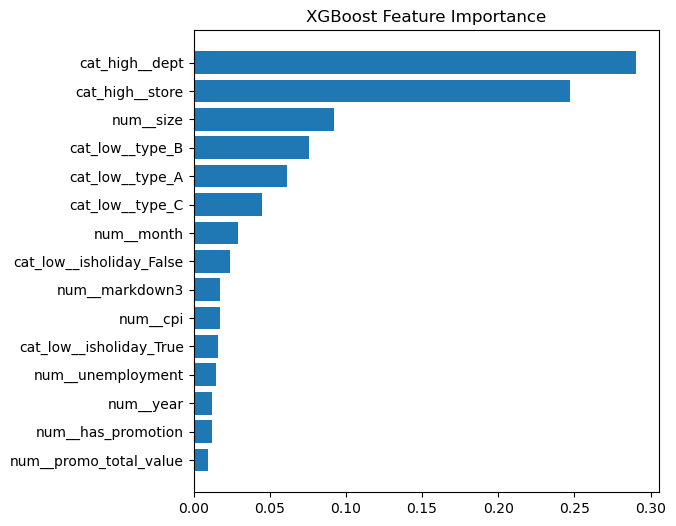

In [119]:
plt.figure(figsize=(6, 6))
plt.barh(xgb_importance_df["all_features"],xgb_importance_df["importances"])
plt.title("XGBoost Feature Importance")
#plt.invert_yaxis()
# plt.xlabel("Importance (Gain)")
# plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

### Hyper parameter tuning using random search on Xgboost model 

In [120]:
#### Do not Delete this 
# 3.Hyperparameter tuning (GridSearchCV)
# from sklearn.model_selection import GridSearchCV, KFold
# #  define CV
# cv = KFold(n_splits=3, shuffle=True, random_state=42)

# # 3.1 define parameters to try (small + fast)
# param_grid = {
#     "xgboost__learning_rate": [0.05, 0.1],
#     "xgboost__subsample": [0.7, 0.8],
#     "xgboost__colsample_bytree": [0.6, 0.8,1],
#     "xgboost__min_child_weight": [1, 5,10],
# }

# # 3.2 grid search runs CV multiple times internally
# grid = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     cv=cv,
#     scoring="neg_root_mean_squared_error",
#     n_jobs=-1,
#     verbose=1
# )

# # 3.3 fit grid ONLY on training data
# grid.fit(X_train, y_train)
# print("Best CV RMSE:", -grid.best_score_)      # best_score_ is negative RMSE
# print("Best Params:", grid.best_params_)

# # 4. Final Model (Best estimator) + Train/Test Evaluation
# best_xgboost_model = grid.best_estimator_

# # Train RMSE
# y_pred_train = best_xgboost_model.predict(X_train)
# train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
# print("Train RMSE:", train_rmse)

# # Test prediction
# y_pred_best = best_xgboost_model.predict(X_test)

# print("Test MAE :", mean_absolute_error(y_test, y_pred_best))
# print("Test R2  :", r2_score(y_test, y_pred_best))

# test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
# print("Test RMSE:", test_rmse)

# Fitting 3 folds for each of 16 candidates, totalling 48 fits
# Best CV RMSE: 6477.612484980379
# Best Params: {'xgboost__colsample_bytree': 0.8, 'xgboost__learning_rate': 0.1, 'xgboost__min_child_weight': 1, 'xgboost__subsample': 0.8}
# Train RMSE: 6070.975586979595
# Test MAE : 3463.4780731855453
# Test R2  : 0.9090476841153273
# Test RMSE: 6301.834785105831


In [121]:
# random search cv :
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import numpy as np

xgb = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)

model = Pipeline(steps=[("preprocess", preprocessor),("xgb", xgb)])

tscv = TimeSeriesSplit(n_splits=3)

param_dist = {
    "xgb__n_estimators": [300, 450, 600],
    "xgb__learning_rate": [0.05, 0.08],
    "xgb__max_depth": [5,6,7,8],
    "xgb__min_child_weight": [1, 5, 10],
    "xgb__gamma": [0, 0.1, 0.3],
    "xgb__subsample": [0.7, 0.8, 0.9],
    "xgb__colsample_bytree": [0.7, 0.8, 0.9],
    "xgb__reg_lambda": [1.0, 2.0,5.0],
    "xgb__reg_alpha": [0.0, 0.01, 0.1],
}

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)
print("Best RMSE:", -search.best_score_)
print("Best Params:", search.best_params_)
best_xgb = search.best_estimator_

# predictions
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

# RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae  = mean_absolute_error(y_test, y_test_pred)
test_r2   = r2_score(y_test, y_test_pred)

print("Test RMSE:", test_rmse)
print("Test MAE :", test_mae)
print("Train RMSE:", train_rmse)
print("Test R²  :", test_r2)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RMSE: 8257.378837828794
Best Params: {'xgb__subsample': 0.7, 'xgb__reg_lambda': 2.0, 'xgb__reg_alpha': 0.0, 'xgb__n_estimators': 300, 'xgb__min_child_weight': 1, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0.1, 'xgb__colsample_bytree': 0.7}
Test RMSE: 6993.193849402068
Test MAE : 4159.418361084791
Train RMSE: 6872.9046952118515
Test R²  : 0.8844290757598369


In [122]:
model_names1 = [ "Dummy", "Baseline", "Linear", "Ridge", "Random Forest", "XGBoost","XGBoost_tuned"]

rmse_values = [ dummy_test_rmse, baseline_test_rmse, lr_test_rmse, ridge_test_rmse, rf_test_rmse, xgb_test_rmse,test_rmse ]

r2_values   = [dummy_test_r2,   baseline_test_r2,   lr_test_r2,   ridge_test_r2,   rf_test_r2,   xgb_test_r2,test_r2]



In [123]:
print("len(model_names):", len(model_names1))
print("len(rmse_values):", len(rmse_values))

len(model_names): 7
len(rmse_values): 7


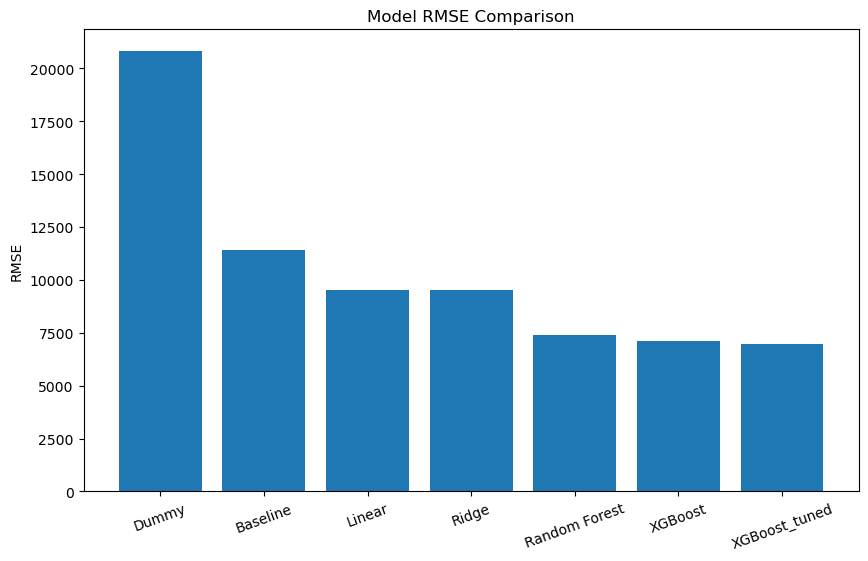

In [124]:
#plt.figure(figsize=(6,6))
model_names_all = ["Dummy", "Baseline", "Linear", "Ridge", "Random Forest", "XGBoost","XGBoost_tuned"]

rmse_values_all = [dummy_test_rmse,baseline_test_rmse,lr_test_rmse,ridge_test_rmse,rf_test_rmse,xgb_test_rmse,test_rmse ]

# plt.bar(model_names1, rmse_values)
# plt.ylabel("RMSE")
# plt.title("Model RMSE Comparison")
# plt.show()
plt.figure(figsize=(10,6))
plt.bar(model_names_all, rmse_values_all)
plt.ylabel("RMSE")
plt.title("Model RMSE Comparison")
plt.xticks(rotation=20)
plt.show()


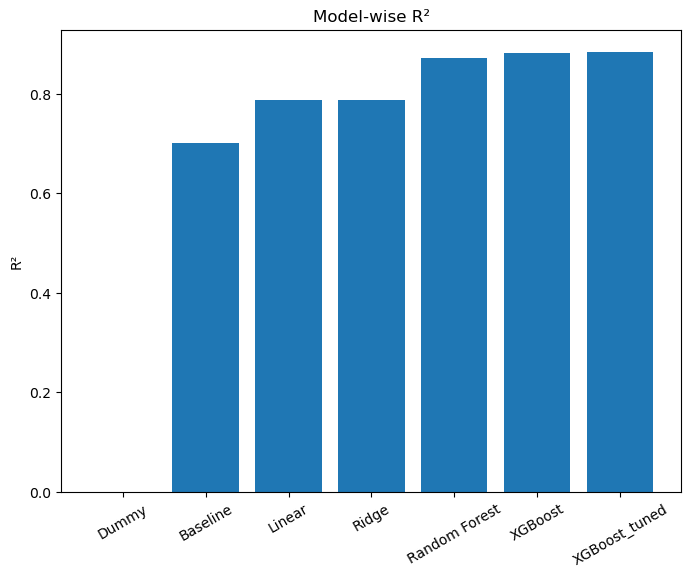

In [125]:
model_names_all1 = ["Dummy", "Baseline", "Linear", "Ridge", "Random Forest", "XGBoost","XGBoost_tuned"]

r2_values_all = [dummy_test_r2,baseline_test_r2,lr_test_r2,ridge_test_r2,rf_test_r2,xgb_test_r2,test_r2]
plt.figure(figsize=(8,6))
plt.bar(model_names_all1, r2_values)
plt.ylabel("R²")
plt.title("Model-wise R²")
plt.xticks(rotation=30)
plt.show()

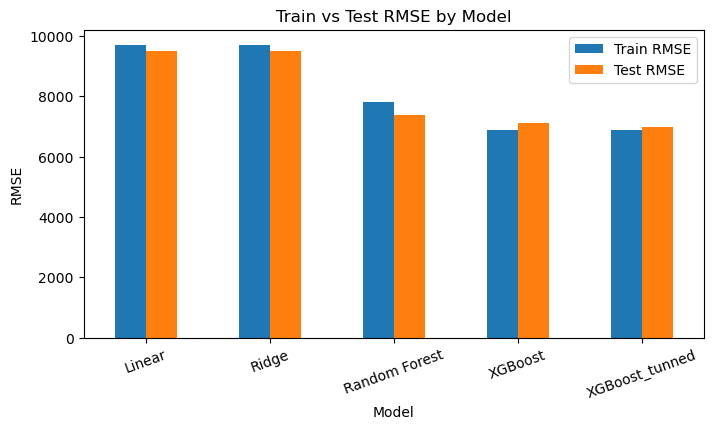

In [126]:
rmse_df = pd.DataFrame({
    "Model": ["Linear", "Ridge", "Random Forest", "XGBoost","XGBoost_tunned"],
    "Train RMSE": [lr_train_rmse, ridge_train_rmse, rf_train_rmse, xgb_train_rmse,train_rmse],
    "Test RMSE":  [lr_test_rmse,  ridge_test_rmse,  rf_test_rmse,  xgb_test_rmse,test_rmse]
})

rmse_df.set_index("Model").plot(kind="bar", figsize=(8,4))

plt.ylabel("RMSE")
plt.title("Train vs Test RMSE by Model")
plt.xticks(rotation=20)
plt.show()